# dot calculation

By utilizing the structure of the Amat, we can compute the vector matrix product in a more efficient way.

In this notebook, we will check the faster way actually works and compare the performance with the naive way.


In [1]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from exputils.Amat.get import get_Amat
from exputils.dot.calc_dot import calc_dot
from exputils.dot.get_topK_Amat import get_topK_Amat
from exputils.stabilizer_group import total_stabilizer_group_size
from exputils.state.random_ket import make_random_quantum_state

n=3
[k|progress|range]: 1 | 1.20000e+02/1.08000e+03 | [0.01721, 0.87813] | 1[ms]
[k|progress|range]: 2 | 5.68000e+02/1.08000e+03 | [0.01721, 0.87813] | 1[ms]
[k|progress|range]: 3 | 1.08000e+03/1.08000e+03 | [0.01721, 0.87813] | 2[ms]
 calculation time : 2[ms]
t1-t0=0.0021326999994926155
t2-t1=0.9420293999864953
t3-t2=0.315610600009677
Counter({8: 512, 4: 448, 2: 112, 1: 8})


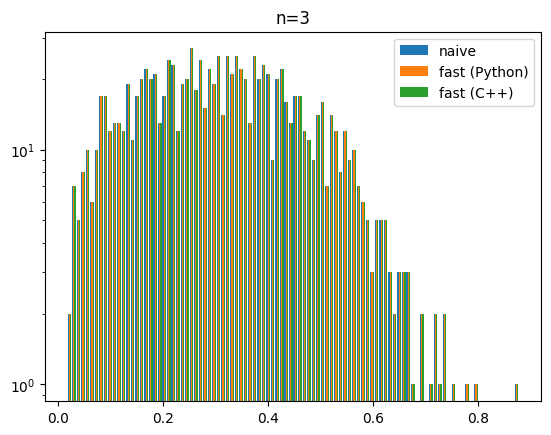

n=4
[k|progress|range]: 1 | 4.96000e+02/3.67200e+04 | [0.00646, 0.58428] | 1[ms]
[k|progress|range]: 2 | 4.97600e+03/3.67200e+04 | [0.00248, 0.66150] | 2[ms]
[k|progress|range]: 3 | 2.03360e+04/3.67200e+04 | [0.21602, 0.69257] | 4[ms]
[k|progress|range]: 4 | 3.67200e+04/3.67200e+04 | [0.28805, 0.69257] | 6[ms]
 calculation time : 6[ms]
t1-t0=0.0009817999962251633
t2-t1=0.0657333999988623
t3-t2=0.2782619000063278
Counter({16: 4459, 8: 4166, 4: 1241, 2: 129, 1: 5})


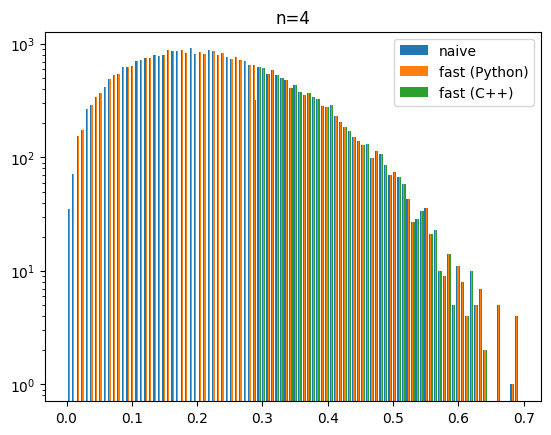

n=5
[k|progress|range]: 1 | 2.01600e+03/2.42352e+06 | [0.00392, 0.39928] | 2[ms]
[k|progress|range]: 2 | 4.16960e+04/2.42352e+06 | [0.21426, 0.49106] | 24[ms]
[k|progress|range]: 3 | 3.59136e+05/2.42352e+06 | [0.32731, 0.57949] | 48[ms]
[k|progress|range]: 4 | 1.37494e+06/2.42352e+06 | [0.38172, 0.59642] | 55[ms]
[k|progress|range]: 5 | 2.42352e+06/2.42352e+06 | [0.40270, 0.59912] | 70[ms]
 calculation time : 70[ms]
t1-t0=0.12595450000662822
t2-t1=5.119644399994286
t3-t2=0.4183269999921322
Counter({32: 4564, 16: 4230, 8: 1127, 4: 79})


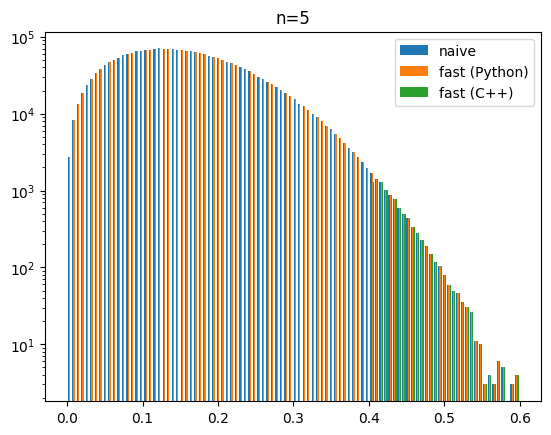

In [3]:
# g++ exputils/cpp/calc_dot.cpp -o exputils/cpp/calc_dot.exe -std=c++17 -O2 -mtune=native -march=native -fopenmp -lz

for is_real_mode in [False, True]:
    for n in [3, 4, 5]:
        print(f"{n=}")

        random.seed(0)
        psi = make_random_quantum_state("pure", n, seed=0)
        if is_real_mode:
            psi = psi.real

        Amat = get_Amat(n)
        if is_real_mode:
            Amat = Amat[:, np.abs(Amat.imag).sum(axis=0) == 0]
        t0 = time.perf_counter()
        ansSlow = np.array(psi).conj() @ Amat
        t1 = time.perf_counter()
        ansFast = calc_dot(n, psi.tolist())
        t2 = time.perf_counter()
        states = get_topK_Amat(n, psi, K=10000, is_dual_mode=False, verbose=True)
        ansFast2 = np.abs(psi.conjugate() @ states)
        t3 = time.perf_counter()
        print(f"{t1-t0=}")
        print(f"{t2-t1=}")
        print(f"{t3-t2=}")
        print(Counter(np.count_nonzero(states.toarray(), axis=0)))

        plt.hist([np.abs(ansSlow), np.abs(ansFast), np.abs(ansFast2)], bins=100)
        plt.title(f"n={n}")
        plt.legend(["naive", "fast (Python)", "fast (C++)"])
        plt.yscale("log")
        plt.show()

        if not is_real_mode:
            assert len(ansSlow) == len(ansFast)
            assert np.allclose(np.sort(ansSlow), np.sort(ansFast))

n=6 total_stabilizer_group_size(n)=315057600
psi[:10]=array([ 0.00191592-0.055118j  ,  0.05823157+0.03303339j,
       -0.0873583 -0.00839837j, -0.042261  -0.06658054j,
       -0.04508918-0.03069197j, -0.05638643-0.08410659j,
        0.0249202 +0.0817603j , -0.03569263-0.11142187j,
        0.14494395-0.06691227j, -0.09171176+0.03051833j])
[k|progress|range]: 1 | 8.12800e+03/3.15058e+08 | [0.00058, 0.36886] | 4[ms]
[k|progress|range]: 2 | 3.41440e+05/3.15058e+08 | [0.23763, 0.44131] | 98[ms]
[k|progress|range]: 3 | 6.05536e+06/3.15058e+08 | [0.31615, 0.47986] | 302[ms]
[k|progress|range]: 4 | 4.87193e+07/3.15058e+08 | [0.35864, 0.48983] | 370[ms]
[k|progress|range]: 5 | 1.80840e+08/3.15058e+08 | [0.38109, 0.53119] | 400[ms]
[k|progress|range]: 6 | 3.15058e+08/3.15058e+08 | [0.38991, 0.53119] | 506[ms]
 calculation time : 506[ms]
t1-t0=0.9856931999966037
Counter({32: 4200, 64: 3830, 16: 1646, 8: 300, 4: 24})


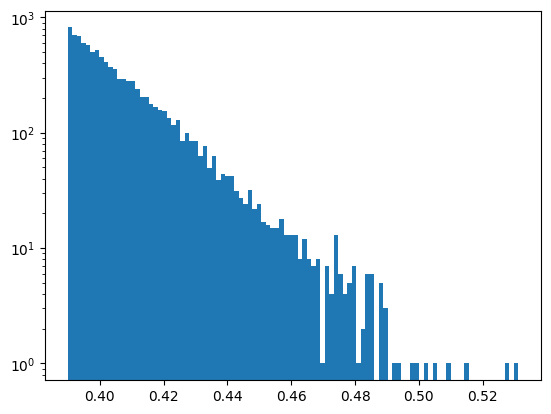

n=7 total_stabilizer_group_size(n)=81284860800
psi[:10]=array([ 0.07913827+0.06814959j,  0.00593093+0.01811256j,
        0.05109879-0.00323261j,  0.02199331-0.00808749j,
       -0.08410508-0.00334621j,  0.05044391-0.01531157j,
       -0.05669442+0.08172552j, -0.01057939-0.05585817j,
        0.14989151-0.01841798j, -0.10853592+0.06166335j])
[k|progress|range]: 1 | 3.26400e+04/8.12849e+10 | [0.09567, 0.30373] | 8[ms]
[k|progress|range]: 2 | 2.76365e+06/8.12849e+10 | [0.21003, 0.34968] | 381[ms]
[k|progress|range]: 3 | 9.95194e+07/8.12849e+10 | [0.26630, 0.37190] | 1444[ms]
[k|progress|range]: 4 | 1.64761e+09/8.12849e+10 | [0.30183, 0.41110] | 2499[ms]
[k|progress|range]: 5 | 1.28338e+10/8.12849e+10 | [0.32515, 0.41110] | 2990[ms]
[k|progress|range]: 6 | 4.69251e+10/8.12849e+10 | [0.33910, 0.41908] | 3716[ms]
[k|progress|range]: 7 | 8.12849e+10/8.12849e+10 | [0.34461, 0.41908] | 4361[ms]
 calculation time : 4362[ms]
t1-t0=6.0444480999867665
Counter({64: 4239, 128: 4052, 32: 1480, 16: 219,

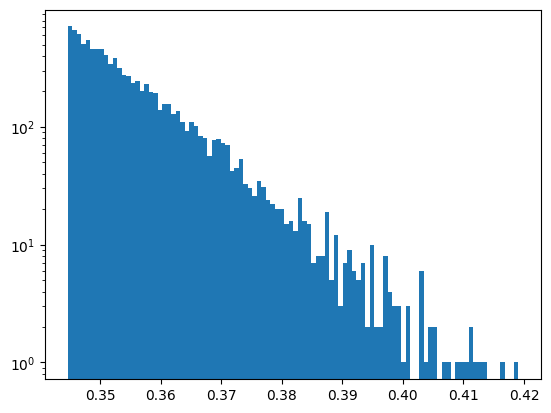

n=8 total_stabilizer_group_size(n)=41780418451200
psi[:10]=array([-0.02468419-0.01300555j, -0.04743796-0.01841991j,
       -0.04517999+0.00046806j, -0.03190195-0.05473635j,
        0.03236416-0.00138037j,  0.00424968-0.07011695j,
        0.0580995 -0.01847172j,  0.07891767-0.06241548j,
        0.08388194+0.01988365j,  0.03656884+0.02063767j])
[k|progress|range]: 1 | 1.30816e+05/4.17804e+13 | [0.10188, 0.20786] | 21[ms]
[k|progress|range]: 2 | 2.22390e+07/4.17804e+13 | [0.17865, 0.26887] | 1002[ms]
[k|progress|range]: 3 | 1.61403e+09/4.17804e+13 | [0.22062, 0.29796] | 3017[ms]
[k|progress|range]: 4 | 5.42491e+10/4.17804e+13 | [0.24822, 0.31185] | 4939[ms]
[k|progress|range]: 5 | 8.69244e+11/4.17804e+13 | [0.26664, 0.32884] | 12289[ms]
[k|progress|range]: 6 | 6.66477e+12/4.17804e+13 | [0.27869, 0.33431] | 41553[ms]
[k|progress|range]: 7 | 2.41882e+13/4.17804e+13 | [0.28571, 0.33431] | 112848[ms]
[k|progress|range]: 8 | 4.17804e+13/4.17804e+13 | [0.28851, 0.34005] | 177396[ms]
 calculatio

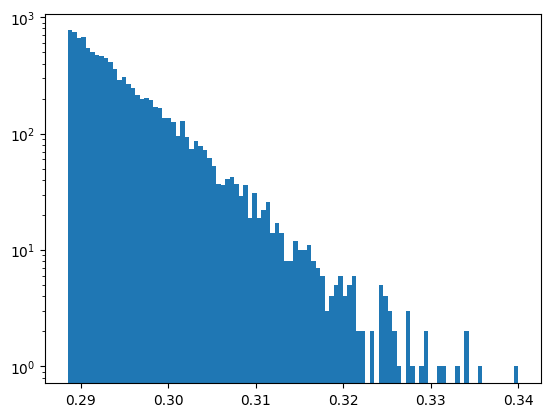

In [7]:
# for n in [6, 7, 8, 9]:
for n in [6, 7, 8, 9]:
    print(f"{n=} {total_stabilizer_group_size(n)=}")

    random.seed(0)
    psi = make_random_quantum_state("pure", n, seed=0)
    if n == 9:
        psi = psi.real
    print(f"{psi[:10]=}")

    t0 = time.perf_counter()
    states = get_topK_Amat(n, psi, K=10000, is_dual_mode=False, verbose=True)
    ans = np.abs(psi.conj().T @ states)
    t1 = time.perf_counter()
    print(f"{t1-t0=}")
    print(Counter(np.count_nonzero(states.toarray(), axis=0)))

    if n <= 5:
        ansSlow = np.abs(calc_dot(n, psi.tolist()))
        plt.hist([ans, ansSlow], bins=100)
    else:
        plt.hist(ans, bins=100)
    plt.yscale("log")
    plt.show()